In [1]:
import numpy as np
import galois
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.insert(1, "../")

from modules.utils import *
from modules.pcm_management import *
from modules.bp_decoder_hp_reg import *

GF4 = galois.GF(4)

# Index-based representation

The BP decoder exchanges messages over the edges of the Tanner. It is implemented using an index-based representation of the stabilizer matrix. During the variable node (VN) update, messages are written into the matrix *VN_to_CN_data*. Each row *n* of this matrix contains the messages from VN *n* to all neighboring check nodes (CNs). This matrix has the same shape as the matrices *Mr* and *Mc*, which act as a lookup table to implement the set $\mathcal{M}(n)$, described on p. 20 in the thesis. This way, messages can be efficiently "redirected" using a more compact representation than the sparse stabilizer matrix. This is described further below.

Note that for an irregular stabilizer matrix, not all VNs have the same degree. Thus, rows of *VN_to_CN_data* (and *Mr* and *Mc*) have to be padded to the maximum degree among all VNs. We use the void entry (-1) to indicate the "non-existence" of the remaining connections in a row.

During the CN update, the entries of *VN_to_CN_data* have to be collected. However, each row of this matrix corresponds to the "VN perspective". To obtain the incoming messages from the perspective of a CN, the entries of *VN_to_CN_data* have to be reordered. This is achieved using the matrices *Nr* and *Nc*, which implement the set $\mathcal{N}(m)$ (also described on p. 20).

Since each row *m* of *Nr* contains the indices of the VNs connected to the corresponding CN *m*, we can "collect" all incoming messages to CN *m* by reading the rows Nr[m] of *VN_to_CN_data*. The corresponding column for each row is stored in Nc[m]. 

In other words, to access all incoming message to CN *m*, we read *VN_to_CN_data* at the rows stored in Nr[m] and the corresponding columns stored in *Nc*.

During the CN update, messages from CN *m* are written into the matrix *CN_to_VN_data*. They are then reordered into the "VN perspective" by using the matrices *Mr* and *Mc*.

The *QuantumCode* class computes *Nr*, *Nc*, *Mr*, and *Mc* when a code is read using the method *read_mode*:

In [2]:
# read in the Steane code
qcode = QuantumCode()
qcode.read_mode("../codes/steane_7_1.alist", css_bool=True)

In [3]:
# (sparse) stabilizer matrix
qcode.H

array([[0, 0, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 2, 2, 2, 2],
       [0, 2, 2, 0, 0, 2, 2],
       [2, 0, 2, 0, 2, 0, 2]], dtype=uint8)

In [4]:
qcode.Nr

array([[3, 4, 5, 6],
       [1, 2, 5, 6],
       [0, 2, 4, 6],
       [3, 4, 5, 6],
       [1, 2, 5, 6],
       [0, 2, 4, 6]], dtype=int32)

In [5]:
qcode.Nc

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 1, 2],
       [1, 2, 2, 3],
       [1, 2, 3, 4],
       [1, 3, 3, 5]], dtype=int32)

In [6]:
qcode.Mr

array([[ 2,  5, -1, -1, -1, -1],
       [ 1,  4, -1, -1, -1, -1],
       [ 1,  2,  4,  5, -1, -1],
       [ 0,  3, -1, -1, -1, -1],
       [ 0,  2,  3,  5, -1, -1],
       [ 0,  1,  3,  4, -1, -1],
       [ 0,  1,  2,  3,  4,  5]], dtype=int32)

In [7]:
qcode.Mc

array([[ 0,  0, -1, -1, -1, -1],
       [ 0,  0, -1, -1, -1, -1],
       [ 1,  1,  1,  1, -1, -1],
       [ 0,  0, -1, -1, -1, -1],
       [ 1,  2,  1,  2, -1, -1],
       [ 2,  2,  2,  2, -1, -1],
       [ 3,  3,  3,  3,  3,  3]], dtype=int32)

Note that not for irregular stabilizer matrices, we only need to collect the number of messages according to the degree of the corresponding node. This information is stored in the vectors *N_deg* (VN degrees) and *M_deg* (CN degrees).

In [8]:
qcode.M_deg

array([4, 4, 4, 4, 4, 4])

In [9]:
# example: get indices of neighboring CNs of VN n=0
n = 0
qcode.Mr[n][:qcode.N_deg[n]]

array([2, 5], dtype=int32)

In [10]:
qcode.N_deg

array([2, 2, 4, 2, 4, 4, 6])

In [11]:
# example: get indices of neighboring CNs of CN m=1
m = 1
qcode.Nr[m][:qcode.M_deg[m]]

array([1, 2, 5, 6], dtype=int32)

For demonstration purposes, let us define the matrices *CN_to_VN_data* and *VN_to_CN_data* with strings, indicating which message the entries correspond to. The entries "-1" are void entries to pad the matrices.

In [12]:
CN_to_VN_data = np.zeros_like(qcode.Nr).astype(str)

for n, row in enumerate(qcode.Nr):
    for m, column in enumerate(row):
        if qcode.Nr[n, m] != -1:
            CN_to_VN_data[n, m] = f"c{n} -> v{row[m]}"
        else:
            CN_to_VN_data[m, n] = "-1"
            
CN_to_VN_data

array([['c0 -> v3', 'c0 -> v4', 'c0 -> v5', 'c0 -> v6'],
       ['c1 -> v1', 'c1 -> v2', 'c1 -> v5', 'c1 -> v6'],
       ['c2 -> v0', 'c2 -> v2', 'c2 -> v4', 'c2 -> v6'],
       ['c3 -> v3', 'c3 -> v4', 'c3 -> v5', 'c3 -> v6'],
       ['c4 -> v1', 'c4 -> v2', 'c4 -> v5', 'c4 -> v6'],
       ['c5 -> v0', 'c5 -> v2', 'c5 -> v4', 'c5 -> v6']], dtype='<U11')

In [13]:
VN_to_CN_data = np.zeros_like(qcode.Mr).astype(str)

for m, row in enumerate(qcode.Mr):
    for n, column in enumerate(row):
        if qcode.Mr[m, n] != -1:
            VN_to_CN_data[m, n] = f"v{m} -> c{row[n]}"
        else:
            VN_to_CN_data[m, n] = "-1"
            
VN_to_CN_data

array([['v0 -> c2', 'v0 -> c5', '-1', '-1', '-1', '-1'],
       ['v1 -> c1', 'v1 -> c4', '-1', '-1', '-1', '-1'],
       ['v2 -> c1', 'v2 -> c2', 'v2 -> c4', 'v2 -> c5', '-1', '-1'],
       ['v3 -> c0', 'v3 -> c3', '-1', '-1', '-1', '-1'],
       ['v4 -> c0', 'v4 -> c2', 'v4 -> c3', 'v4 -> c5', '-1', '-1'],
       ['v5 -> c0', 'v5 -> c1', 'v5 -> c3', 'v5 -> c4', '-1', '-1'],
       ['v6 -> c0', 'v6 -> c1', 'v6 -> c2', 'v6 -> c3', 'v6 -> c4',
        'v6 -> c5']], dtype='<U11')

To access all incoming messages to CN m=0, we have to read *VN_to_CN_data* at the rows Nr[0] and the corresponding columns Nc[0]. Note that CN m=0 is of degree deg=4 and we hence only read the first 4 entries of Nr and Nc.

In [14]:
# access incoming messages to CN m=0. Note that CN m=0 is of degree 4
m = 0
VN_to_CN_data[qcode.Nr[m, :qcode.M_deg[m]], qcode.Nc[m, :qcode.M_deg[m]]]

array(['v3 -> c0', 'v4 -> c0', 'v5 -> c0', 'v6 -> c0'], dtype='<U11')

To access all incoming messages to VN n=0, we have to read *CN_to_VN_data* at the rows Mr[0] and the corresponding columns Mc[0]. Note that VN n=0 is of degree deg=2 and we hence only read the first 2 entries of Mr and Mc.

In [15]:
# access incoming messages to VN n=0. Note that VN n=0 is of degree 2
n = 0
CN_to_VN_data[qcode.Mr[n, :qcode.N_deg[n]], qcode.Mc[n, :qcode.N_deg[n]]]

array(['c2 -> v0', 'c5 -> v0'], dtype='<U11')

### Parallel and Serial Schedule, Codes with Constant and Non-Constant CN degree

In the scope of this thesis, BP decoding was implemented in different ways. While the reordering described above is a key concept in all implementations, differences lie in the parallelizability.

This parallelizability depends on both, the update schedule (parallel vs. serial) as well as the code (constant CN degree vs. non-constant CN degree). 

If a regular LDPC code with $d_v = 3, d_c = 4$ is used to construct a symmetric HP code, the resulting code has a constant CN degree of 7:

In [16]:
# read in the [[400, 16]] HP code
qcode = QuantumCode()
qcode.read_mode("../codes/hp_400_16.alist", css_bool=True)
qcode.Nr

array([[ 32,  96, 144, ..., 257, 259, 260],
       [ 33,  97, 145, ..., 260, 262, 267],
       [ 34,  98, 146, ..., 256, 258, 261],
       ...,
       [248, 249, 252, ..., 301, 361, 385],
       [245, 246, 248, ..., 302, 362, 386],
       [241, 244, 246, ..., 303, 363, 387]], dtype=int32)

The module *bp_decoder_hp_reg.py* contains the implementation of both, a parallel and a serial update schedule for such symmetric HP codes. 

It's functions are explained in the notebook *demo_bp_decoder_hp_reg*.

On the other hand, HP codes constructed from irregular classical codes (such as the [[129, 28]] HP code) don't have a constant CN degree and hence are not as parallelizable. The decoder can thus be used for a more general class of HP codes but runs significantly slower, compared to the implementation designed for symmetric HP codes.

The module *bp_decoder_hp_ireg.py* contains the implementation of both, a parallel and a serial update schedule for this (more general) case of HP codes. 

It's functions are explained in the notebook *demo_bp_decoder_hp_ireg*.

# Basics of BP decoding

While the update functions for VNs and CNs depend on the update schedule and properties of the code, the basic set-up of all implementations is identical. We discuss this set-up using the parallel decoder for the symmetric [[400, 16]] HP code (as this allows for the simplest demonstration).

The decoders are implemented as classes. These classes have variables that represent the code as well as variables that represent and document the current state of the decoder (i.e. the beliefs). In addition, a decoder has methods to update messages and check for convergence.

In [17]:
# read in the [[400, 16]] HP code
qcode = QuantumCode()
qcode.read_mode("../codes/hp_400_16.alist", css_bool=True)

In addition to the matrices *Nr*, *Nc*, *Mr* and *Mc*, we require information on the edge types associated to each connection. This information can be accessed via the matrices *N_pauli_lookup* (identical shape to *Nr*) and *M_pauli_lookup* (identical shape to *Mr*):

In [18]:
qcode.N_pauli_lookup

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

In [19]:
qcode.M_pauli_lookup

array([[ 1,  1,  1, ...,  2, -1, -1],
       [ 1,  1,  1, ...,  2, -1, -1],
       [ 1,  1,  1, ...,  2, -1, -1],
       ...,
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2]], dtype=int32)

Also, a decoder requires an initial value for $\epsilon_0$. With this, we can instantiate a decoder:

In [20]:
epsilon = 0.01

In [21]:
decoder = DecoderParallel(qcode.Mr, qcode.Mc, qcode.M_pauli_lookup,
                          qcode.Nr, qcode.Nc, qcode.N_pauli_lookup,
                          epsilon)

A decoder has the variables *error* and *z* to represent the error that is to be decoded and it's corresponding syndrome. Initially, these variables are all-zero:

In [22]:
decoder.error

GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
decoder.z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The error can be set using the method *set_error*. This also updates the syndrome $z$, using the method *compute_syndrome*, which uses the index-based representation to efficiently compute the syndrome:

In [24]:
error = np.zeros(qcode.n, dtype = np.uint8)
error[[0, 1, 2, 3]] = [2, 1, 2, 3]

In [25]:
decoder.set_error(error)

In [26]:
decoder.error

GF([2, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
decoder.z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Initially, the matrices *VN_to_CN_data* and *CN_to_VN_data* are set to (-1) everywhere:

In [28]:
decoder.VN_to_CN_data

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [29]:
decoder.CN_to_VN_data

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

The matrix *VN_to_CN_data* can be initialized using the method *initialization*. This initialization depends on the variable *Lambda*, which represents the a-priori beliefs (defined on p. 21 in the thesis):

In [30]:
decoder.Lambda

array([[5.69373214, 5.69373214, 5.69373214],
       [5.69373214, 5.69373214, 5.69373214],
       [5.69373214, 5.69373214, 5.69373214],
       ...,
       [5.69373214, 5.69373214, 5.69373214],
       [5.69373214, 5.69373214, 5.69373214],
       [5.69373214, 5.69373214, 5.69373214]])

In [31]:
decoder.initialization()

In [32]:
decoder.VN_to_CN_data

array([[5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788],
       [5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788],
       [5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788],
       ...,
       [5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788],
       [5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788],
       [5.00405788, 5.00405788, 5.00405788, ..., 5.00405788, 5.00405788,
        5.00405788]])

The current estimate of the error (defined in line 13 of Algorithm 1 on p. 22 in the thesis) can be updated using the method *update_estimates*. This method also updates the syndrome of the estimated error. These variables can be accessed via decoder.error_estimate and decoder.z_estimate:

In [33]:
decoder.update_estimates()

In [34]:
decoder.error_estimate

GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
decoder.z_estimate

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Note that the decoding procedure is terminated as soon as the estimated syndrome equals the true syndrome (i.e. if decoder.z == decoder.z_estimate for all entries). This can be checked using the method *early_stopping*:

In [36]:
decoder.early_stopping()

False

We can now propagate messages between VNs and CNs using the methods *update_CNs* and *update_VNs*:

In [37]:
N_iter = 4

for i in range(N_iter):
    decoder.update_CNs()
    decoder.update_VNs()
    decoder.update_estimates()
    print(f"Decoder converged? {decoder.early_stopping()}")

Decoder converged? False
Decoder converged? False
Decoder converged? False
Decoder converged? True


The process of setting an error, initializing the decoder and propagating messages is summarized into the function *decode*. This message is passed an error, an update function (could be parallel or serial), a maximum number of iterations and three booleans, indicating if:

- init: Indicates whether the decoder should be (re-)initialized. When not specified this is set to True but False may be helpful to resume decoding from a certain state

- early_stopping: Indicates whether decoding should be terminated after a valid syndrome was found

- log_history: Indicates whether the beliefs should be stored into the list *Gamma_history_list*. This is helpful to plot the decoding histories.

Note that the argument *update* is a function which describes the order of the nodes in which the update functions are called. These functions are defined in the decoder class. As the two schedules require different code in the update (mostly due to efficient parallelization), there exist two classes, DecoderParallel and DecoderSerial. Thus, in the parallel case we pass decoder.parallel, in the serial case we pass decoder.serial_VN or decoder.serial_VN_schedule. For more details on these function, see the Notebooks *parallel_bp_decoding* and *serial_bp_decoding*.

In [38]:
# reinstantiate a parallel decoder
decoder = DecoderParallel(qcode.Mr, qcode.Mc, qcode.M_pauli_lookup,
                          qcode.Nr, qcode.Nc, qcode.N_pauli_lookup,
                          epsilon)

# function returns the estimated error
decoder.decode(error, decoder.parallel, N_iter=12, init=True, early_stopping=True, log_history=True)

GF([2, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

We can now use decoder.Gamma_history_list to obtain the history of beliefs and plot them:

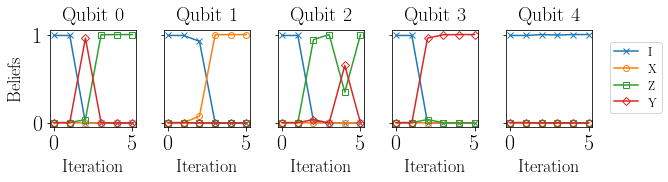

In [39]:
# compute the history of beliefs from decoder.Gamma_history_list
beliefs_history = p_from_Gamma_array(np.array(decoder.Gamma_history_list))

# set latex font for the plot
mpl.rc('font',**{"size": "22", 'family':'serif','serif':['STIXGeneral']})
mpl.rc('text', usetex=True)

plot_indices = [0, 1, 2, 3, 4]
n_plot = len(plot_indices)

# set different markers
markers = ["x", "o", "s", "D"]
marker_sizes = [6, 6, 6, 6]

marker_styles = [dict(marker=markers[i], markersize=marker_sizes[i]) for i in np.arange(len(marker_sizes))]

fig, axes = plt.subplots(nrows=1, ncols=n_plot, figsize=(10, 3), sharey=True)

for qubit_index, (qubit, ax) in enumerate(zip(plot_indices, axes)):
    
    for index, (pauli_error, marker_style) in enumerate(zip(["I", "X", "Z", "Y"], marker_styles)):
        ax.plot(np.arange(beliefs_history.shape[0]), beliefs_history[:, qubit, index], label = pauli_error,
                    ls = '-', lw = 1.5, fillstyle = "none",
                    **marker_style)

        ax.set_title("Qubit " + str(qubit), fontsize=20, pad = 10)
        ax.set_xlabel("Iteration", labelpad = 5, fontsize = 18)
        
        plt.yticks(fontsize = 18)
    
    # only plot label "Beliefs" for the first subplot
    if qubit_index == 0:
        ax.set_ylabel("Beliefs", labelpad = 10, fontsize = 18)
        
    # only plot the legend for the last subplot
    if qubit_index == 4:
        ax.legend(loc = (1.2, 0.15), fontsize = 12)
    
plt.tight_layout()

# Checking for decoding success

Recall that (expressed in GF(4)) decoding succeeds if the sum of the true error and the estimated error lies in the rowspace of the stabilizer matrix. This is efficiently calculated using the function *qcode.stabilizer_check*. For the error decoded above, decoding is successful:

In [40]:
qcode.stabilizer_check(GF4(error) + decoder.error_estimate)

True

Hence, the error estimate only has to be identical to the true error up to an element in the stabilizer (e.g. the sum of rows 0 and 1):

In [41]:
qcode.stabilizer_check(decoder.error_estimate + GF4(error) + GF4(qcode.H[0]) + GF4(qcode.H[1]))

True